## Problem 1
Here we will be dealing with MPS for n-party GHZ- and W-states using the QIT package (http://qit.sourceforge.net):
$$
|\mathrm{GHZ}\rangle_n ={\frac  {|0\rangle ^{{\otimes n}}+|1\rangle ^{{\otimes n}}}{{\sqrt  {2}}}}
$$
$$
|W\rangle_n ={\frac {1}{\sqrt {n}}}(|100...0\rangle +|010...0\rangle +...+|00...01\rangle
$$
We're asked to write down a Matrix Product State for each and calculate the following correlator:
$$
C(\psi, j \leq n) := \langle \psi | X_1 X_j | \psi \rangle - \langle \psi | X_1 | \psi \rangle \langle \psi | X_j | \psi \rangle
$$

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import qit
%matplotlib inline

Let's first do it without MPS, as low-qubit GHZ- and W- states can be easily managed in the computational basis

In [2]:
#n is the number of qubits which should be integer and >= 2

n = 10

def GHZ(n):
    tmp = []
    for i in range(n):
        tmp.append(2)
    return qit.state('GHZ', tmp)

def W(n):
    tmp = []
    for i in range(n):
        tmp.append(2)
    return qit.state('W', tmp)

In [3]:
GHZ(6)

 +0.7071 |000000> +0.7071 |111111>
dim: (2, 2, 2, 2, 2, 2) <- (1,)

In [4]:
W(6)

 +0.4082 |000001> +0.4082 |000010> +0.4082 |000100> +0.4082 |001000> +0.4082 |010000> +0.4082 |100000>
dim: (2, 2, 2, 2, 2, 2) <- (1,)

In [5]:
# here we define Pauli X gate to act on any qubit (numbered k) out of n, k<=1

def X(i):
    x = qit.lmap(np.array([[0, 1], [1, 0]]))
    if i == 1:
        return qit.tensor(x, qit.lmap(np.eye(2**(n-1))))
    else:
        return qit.tensor(qit.lmap(np.eye(2**(i-1))), x, qit.lmap(np.eye(2**(n-i))))

In [6]:
def C_GHZ(j):
    return qit.state.ev(GHZ(n), X(1).data @ X(j).data) - qit.state.ev(GHZ(n), X(1).data) * qit.state.ev(GHZ(n), X(j).data)

def C_W(j):
    return qit.state.ev(W(n), X(1).data @ X(j).data) - qit.state.ev(W(n), X(1).data) * qit.state.ev(W(n), X(j).data)

In [7]:
C_GHZ_array = []
C_W_array = []

for j in range(1,n+1):
    C_GHZ_array.append(C_GHZ(j))
    C_W_array.append(C_W(j))

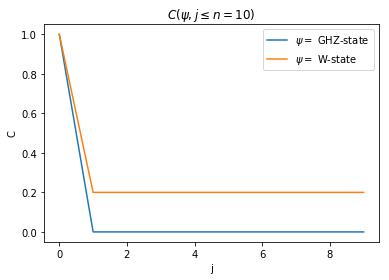

In [8]:
plt.plot(C_GHZ_array)
plt.plot(C_W_array)
plt.title('$C(\psi, j \leq n =%i)$' %n)
plt.ylabel('C')
plt.xlabel('j')
plt.legend(['$\psi=$ GHZ-state', '$\psi=$ W-state'], loc = 'best')
plt.show()

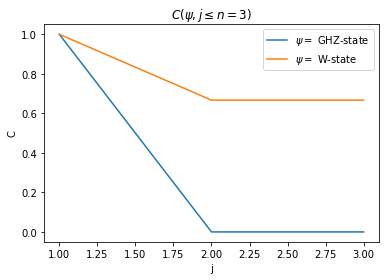

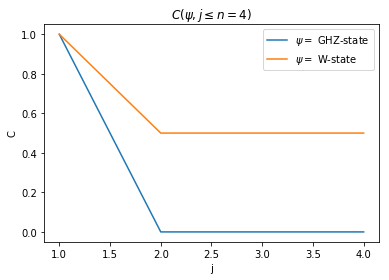

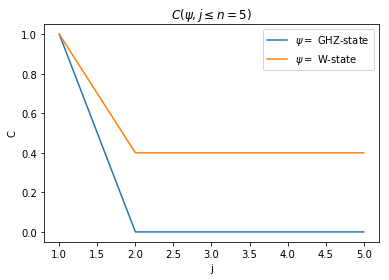

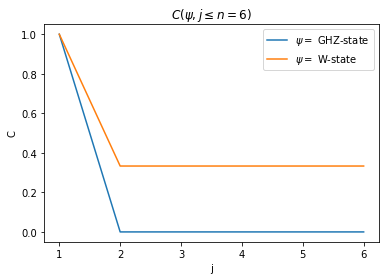

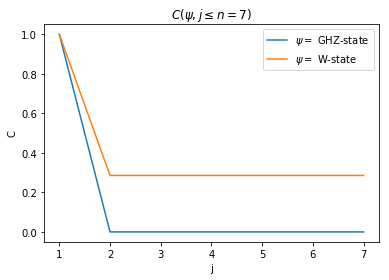

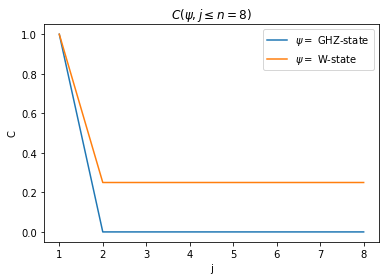

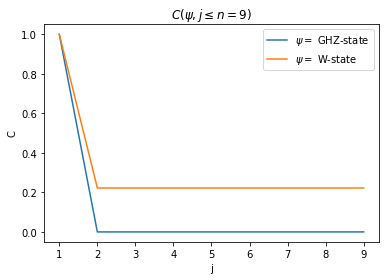

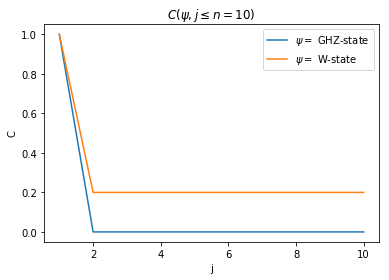

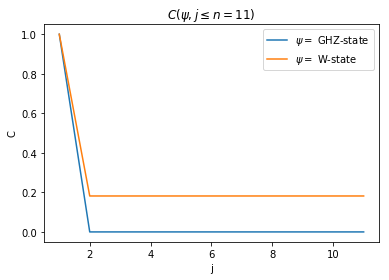

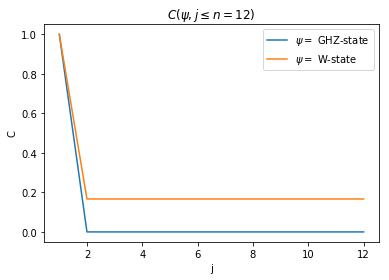

Wall time: 1min 36s


In [9]:
%%time
for n in range(3,13):
    C_GHZ_array = []
    C_W_array = []

    for j in range(1,n+1):
        C_GHZ_array.append(C_GHZ(j))
        C_W_array.append(C_W(j))
    
    plt.plot(range(1,n+1), C_GHZ_array)
    plt.plot(range(1,n+1), C_W_array)
    plt.title('$C(\psi, j \leq n =%i)$' %n)
    plt.ylabel('C')
    plt.xlabel('j')
    plt.legend(['$\psi=$ GHZ-state', '$\psi=$ W-state'], loc = 'best')
    plt.show()

Now let's try to attack the problem with 3 qubits using MPS approach

In [10]:
def GHZ_MPS(n):
    tmp=np.zeros(2**n)
    tmp[0] = (1/np.sqrt(2)) * np.trace(np.linalg.matrix_power(np.array([[1, 0], [0, 0]]), 3))
    tmp[2**n - 1] = (1/np.sqrt(2)) * np.trace(np.linalg.matrix_power(np.array([[0, 0], [0, 1]]), 3))
    return tmp

A_0 = np.array([[1, 0], [1, 0]])
A_1 = np.array([[0, 0], [0, 1]])
B_0 = np.array([[1, 0], [0, 1]])
B_1 = np.array([[0, 1], [0, 0]])
C_0 = np.array([[0, 0], [0, 1]])
C_1 = np.array([[1, 0], [0, 0]])

W_MPS_3 = (1/np.sqrt(3)) * np.array([np.trace(A_0@B_0@C_0), np.trace(A_0@B_0@C_1), np.trace(A_0@B_1@C_0), np.trace(A_0@B_1@C_1), np.trace(A_1@B_0@C_0), np.trace(A_1@B_0@C_1), np.trace(A_1@B_1@C_0), np.trace(A_1@B_1@C_1)])

In [11]:
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])

X_1 = np.kron(X, np.kron(I, I))
X_2 = np.kron(I, np.kron(X, I))
X_3 = np.kron(I, np.kron(I, X))

In [12]:
C_GHZ_MPS_1 = GHZ_MPS(3) @ X_1 @ X_1 @ np.transpose(GHZ_MPS(3)) - GHZ_MPS(3) @ X_1 @ np.transpose(GHZ_MPS(3)) * GHZ_MPS(3) @ X_1 @ np.transpose(GHZ_MPS(3))
C_GHZ_MPS_2 = GHZ_MPS(3) @ X_1 @ X_2 @ np.transpose(GHZ_MPS(3)) - GHZ_MPS(3) @ X_1 @ np.transpose(GHZ_MPS(3)) * GHZ_MPS(3) @ X_2 @ np.transpose(GHZ_MPS(3))
C_GHZ_MPS_3 = GHZ_MPS(3) @ X_1 @ X_3 @ np.transpose(GHZ_MPS(3)) - GHZ_MPS(3) @ X_1 @ np.transpose(GHZ_MPS(3)) * GHZ_MPS(3) @ X_3 @ np.transpose(GHZ_MPS(3))

In [13]:
C_W_MPS_1 = W_MPS_3 @ X_1 @ X_1 @ np.transpose(W_MPS_3) - W_MPS_3 @ X_1 @ np.transpose(W_MPS_3) * W_MPS_3 @ X_1 @ np.transpose(W_MPS_3)
C_W_MPS_2 = W_MPS_3 @ X_1 @ X_2 @ np.transpose(W_MPS_3) - W_MPS_3 @ X_1 @ np.transpose(W_MPS_3) * W_MPS_3 @ X_2 @ np.transpose(W_MPS_3)
C_W_MPS_3 = W_MPS_3 @ X_1 @ X_3 @ np.transpose(W_MPS_3) - W_MPS_3 @ X_1 @ np.transpose(W_MPS_3) * W_MPS_3 @ X_3 @ np.transpose(W_MPS_3)

In [14]:
C_GHZ_MPS_array = np.array([C_GHZ_MPS_1, C_GHZ_MPS_2, C_GHZ_MPS_3])
C_W_MPS_array = np.array([C_W_MPS_1, C_W_MPS_2, C_W_MPS_3])

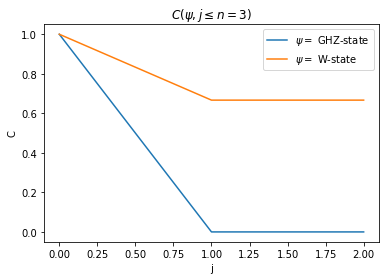

In [15]:
plt.plot(C_GHZ_MPS_array)
plt.plot(C_W_MPS_array)
plt.title('$C(\psi, j \leq n =3)$')
plt.ylabel('C')
plt.xlabel('j')
plt.legend(['$\psi=$ GHZ-state', '$\psi=$ W-state'], loc = 'best')
plt.show()